In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from tqdm import tqdm
from cartopy import crs as ccrs

from nzdownscale.dataprocess.config_local import DATA_PATHS
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS
from nzdownscale.dataprocess import era5, stations, wrf

/home/emily/mambaforge/envs/deepsensor2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
var = 'temperature'
year = 2020

# Load ERA5

In [4]:
process_era5 = era5.ProcessERA5()
era5_var = VAR_ERA5[var]['var_name']
era5_ds = process_era5.load_ds(var, year)
era5_ds = era5_ds.compute() - 273.15

# Load stations

In [5]:
process_stations = stations.ProcessStations()
station_var = VAR_STATIONS[var]['var_name']
station_df = process_stations.load_stations(var, year)

Loading stations:   0%|          | 0/470 [00:00<?, ?it/s]

Filtering stations: 100%|██████████| 211/211 [00:36<00:00,  5.81it/s]


Concatenating stations into pd.DataFrame


In [6]:
station_df

dry_bulb
time       station_name       latitude  longitude          
2020-01-01 AKAROA EWS         -43.80938 172.96574      29.2
           AKITIO EWS         -40.57728 176.44889      25.0
           ALBERT BURN        -44.38112 168.92633      11.0
           ALEXANDRA AWS      -45.21452 169.37549      21.2
           ALEXANDRA EWS      -45.25458 169.38448      17.6
...                                                     ...
2020-12-31 WHATAWHATA 2 EWS   -37.78832 175.06906      23.1
           WHITIANGA AERO AWS -36.83237 175.67542      20.4
           WHITIANGA EWS      -36.82817 175.67231      20.4
           WINCHMORE 2 EWS    -43.78935 171.79032      18.5
           WINDSOR EWS        -45.00829 170.82281      17.4

[1646917 rows x 1 columns]

# Plots

In [7]:
era5_mean = float(era5_ds[era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
station_mean = np.mean(station_df[station_var].values)
print(f'ERA5 overall mean: {era5_mean},\nStation overall mean: {station_mean}')

ERA5 overall mean: 10.18825912475586,
Station overall mean: 11.999528270094972


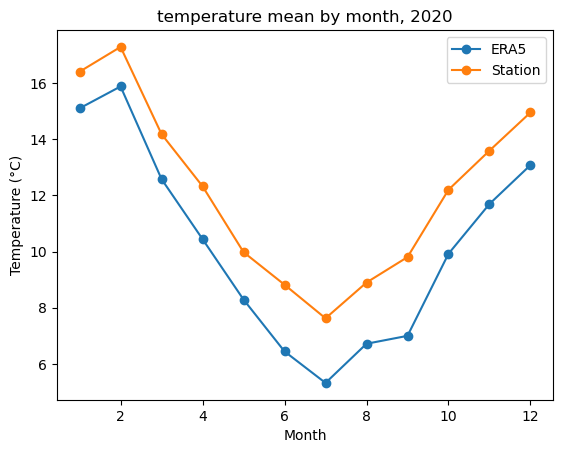

In [8]:
era5_mean_by_month = era5_ds[era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values

station_df_reset = station_df.reset_index()
station_df_reset['time'] = pd.to_datetime(station_df_reset['time'])
station_df_reset = station_df_reset.set_index('time')
station_mean_by_month = station_df_reset[station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.set_title(f'{var} mean by month, {year}')
plt.show();

# By station

In [9]:
stations = station_df_reset['station_name'].unique()

In [17]:
station_data['latitude'].unique()[0]

-43.80938

In [19]:
stats_by_station = {}
for station in tqdm(stations):
    station_data = station_df_reset[station_df_reset['station_name'] == station]
    station_data_vals = station_data[station_var]
    station_mean = station_data_vals.mean()
    station_std = station_data_vals.std()

    era5_data = era5_ds[era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                       longitude=station_data['longitude'].unique()[0],
                                       method='nearest')
    era5_data_vals = era5_data.values
    era5_mean = era5_data_vals.mean()
    era5_std = era5_data_vals.std()

    stats_by_station[station] = {'station_mean': station_mean, 
                                 'station_std': station_std,
                                 'era5_mean': era5_mean,
                                 'era5_std': era5_std}

  0%|          | 0/210 [00:00<?, ?it/s]

100%|██████████| 210/210 [00:14<00:00, 14.89it/s]


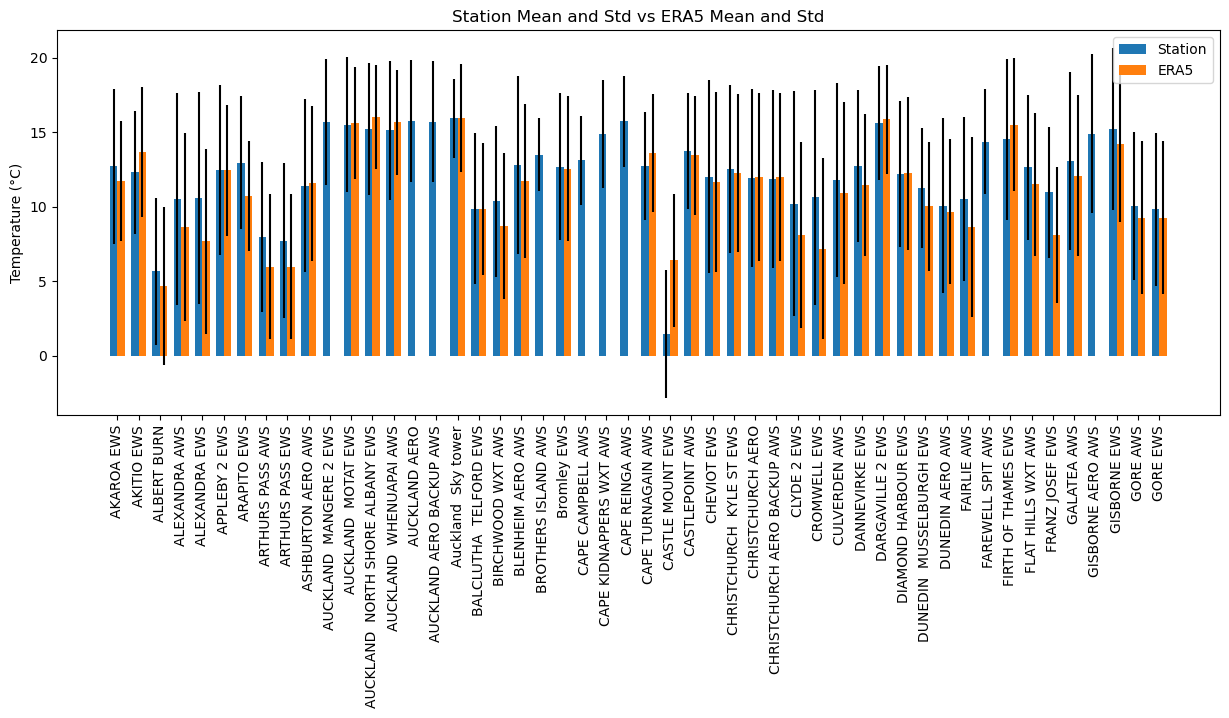

In [24]:
num_stations = len(stats_by_station)

station_names = list(stats_by_station.keys())

station_means = [stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [stats_by_station[station]['station_std'] for station in station_names]

era5_means = [stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('Temperature (°C)')
ax.set_title('Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

# Visualise

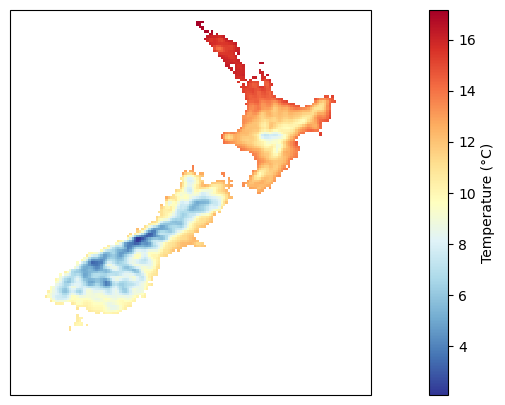

In [32]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = era5_ds[era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap='RdYlBu_r', 
                cbar_kwargs={'label': 'Temperature (°C)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

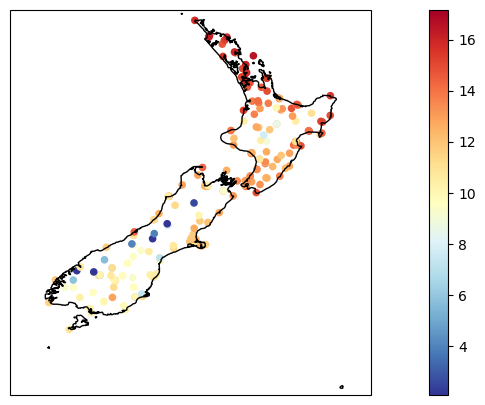

In [34]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[station_var], 
                           cmap='RdYlBu_r',
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

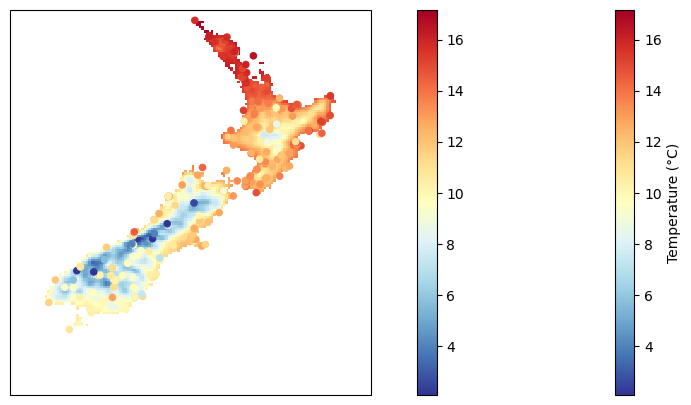

In [35]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap='RdYlBu_r', 
                cbar_kwargs={'label': 'Temperature (°C)'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[station_var], 
                           cmap='RdYlBu_r',
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1129896/2719385774.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')
/tmp/ipykernel_1129896/2719385774.py:16: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')


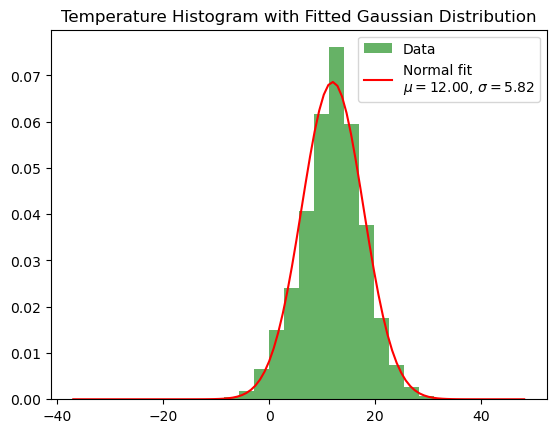

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, lognorm, beta

# Get the pressure data (replace with your actual column name)
data = station_df['dry_bulb'].values

# Plot the histogram of the data
fig, ax = plt.subplots()
ax.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Fit and plot the Normal distribution
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p_norm = norm.pdf(x, mu, std)
ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')

# # Fit and plot the Gamma distribution
# shape, loc, scale = gamma.fit(data, floc=0)
# p_gamma = gamma.pdf(x, shape, loc, scale)
# ax.plot(x, p_gamma, 'b-', label=f'Gamma fit\n$\\alpha={shape:.2f}$, $\\beta={scale:.2f}$')

# # Fit and plot the Log-Normal distribution
# shape_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(data, floc=0)
# p_lognorm = lognorm.pdf(x, shape_lognorm, loc_lognorm, scale_lognorm)
# ax.plot(x, p_lognorm, 'm-', label=f'Log-Normal fit\n$\\mu={shape_lognorm:.2f}$, $\\sigma={scale_lognorm:.2f}$')

# # Fit and plot the Beta distribution (normalize data to [0, 1] range)
# data_norm = (data - min(data)) / (max(data) - min(data))  # Normalize to [0, 1]
# alpha, beta_, loc_beta, scale_beta = beta.fit(data, floc=0, fscale=1)
# p_beta = beta.pdf(x, alpha, beta_, loc_beta, scale_beta)
# ax.plot(x, p_beta, 'm-', label=f'Beta fit\n$\\alpha={alpha:.2f}$, $\\beta={beta_:.2f}$')

# Customize plot
ax.set_title('Temperature Histogram with Fitted Gaussian Distribution')
ax.legend()

plt.show()
